### Task 1 - Image Segmentation

In [ ]:
!pip install Keras-Preprocessing

In [13]:
# @title Downloading
import os
import urllib.request
import zipfile


urls = {
    # "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    # "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    # "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    # "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    # "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    # "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip"

    # "train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    # "train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    # "validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    # "validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",

    "test_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip",
    "test_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Test_GroundTruth.zip"

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            print(f"unzipping {filename} to folder")
            zip_ref.extractall(f"{name}")


# if __name__ == "__main__":
#     download_all()
#     unzip_all()

download_all()
unzip_all()


already exists file test_seg.zip
already exists file test_seg_gt.zip
done downloading all
test_seg.zip
unzipping test_seg.zip to folder
test_seg_gt.zip
unzipping test_seg_gt.zip to folder


In [11]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import cv2
import os
#import shutil

from PIL import Image

In [34]:
img_size = 256

In [2]:
def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)

    #encode
    s1 = resnet50.get_layer("input_1").output  #512x512
    s2 = resnet50.get_layer("conv1_relu").output  #256x256
    s3 = resnet50.get_layer("conv2_block3_out").output  #128x128
    s4 = resnet50.get_layer("conv3_block4_out").output  #64x64

    #bottleneck
    bottleneck = resnet50.get_layer("conv4_block6_out").output  #32x32

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    return model

model = U_Net((256,256,3))
model.summary()
model.save("seg_model.keras")

2024-02-14 11:55:31.790850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 11:55:31.976461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 11:55:31.976513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 11:55:31.978620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 11:55:31.978678: I external/local_xla/xla/stream_executor

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                               

In [3]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            if img is not None:
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
    return [images, i+startind]

seg_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=360,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15
                             )

In [4]:
model = k.models.load_model('seg_model.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=8
spe = 32 #steps per epoch
currentindx1=0
currentindy1=0
currentindx2=0
currentindy2=0
epochs = 80

seg_X_path = "train_seg/ISIC2018_Task1-2_Training_Input"
seg_y_path = "train_seg_gt/ISIC2018_Task1_Training_GroundTruth"

seg_val_X_path = "validation_seg/ISIC2018_Task1-2_Validation_Input"
seg_val_y_path = "validation_seg_gt/ISIC2018_Task1_Validation_GroundTruth"

histories = []
for i in range(epochs+1):
    currentindy1=currentindx1
    currentindy2=currentindy2
    seg_x = load_folder_imgs(seg_X_path, batchsize, currentindx1, (256,256))
    seg_y = load_folder_imgs(seg_y_path, batchsize, currentindy1, (256,256))
    seg_val_x = load_folder_imgs(seg_val_X_path, batchsize, currentindx2, (256,256))
    seg_val_y = load_folder_imgs(seg_val_y_path, batchsize, currentindy2, (256,256))

    train_gt_X = seg_x[0] 
    train_gt_y = seg_y[0]
    currentinx1 = seg_x[1]
    currentiny1 = seg_y[1]

    val_train_gt_X = seg_val_x[0] 
    val_train_gt_y = seg_val_y[0]
    currentinx2 = seg_val_x[1]
    currentiny2 = seg_val_y[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]

    val_train_gt_X = [x//255 for x in val_train_gt_X]
    val_train_gt_y = [x//255 for x in val_train_gt_y]
    val_train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in val_train_gt_y]

    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)

    val_train_gt_X = tf.stack(val_train_gt_X) 
    val_train_gt_y = tf.stack(val_train_gt_y)

    train_generator = seg_datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    val_generator = seg_datagen.flow(x=val_train_gt_X, y=val_train_gt_y, batch_size=batchsize)
    history = model.fit(train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1, validation_data=val_generator)
    histories.append(history)
    print(f"--------------- Done epoch {i} -----------------")

model.save("final_seg_res50.keras")

(8, 256, 256)


2024-02-14 11:56:03.122714: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 11:56:03.395638: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 11:56:03.979085: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 11:56:09.417753: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa63b00a5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 11:56:09.417787: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1707940569.460332   60440 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 25s 35ms/step - loss: 0.7606 - binary_accuracy: 0.5034 - mean_squared_error: 0.2718 - auc: 0.4778 - val_loss: 0.6414 - val_binary_accuracy: 0.7171 - val_mean_squared_error: 0.2243 - val_auc: 0.4812
--------------- Done epoch 0 -----------------
(8, 256, 256)
32/32 [==============================] - 0s 8ms/step - loss: 0.6270 - binary_accuracy: 0.5703 - mean_squared_error: 0.2215 - auc: 0.6593 - val_loss: 0.6403 - val_binary_accuracy: 0.7173 - val_mean_squared_error: 0.2238 - val_auc: 0.4837
--------------- Done epoch 1 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 8ms/step - loss: 0.5704 - binary_accuracy: 0.7040 - mean_squared_error: 0.1948 - auc: 0.6821 - val_loss: 0.6361 - val_binary_accuracy: 0.7181 - val_mean_squared_error: 0.2218 - val_auc: 0.4856
--------------- Done epoch 2 -----------------
(8, 256, 256)
32/32 [==============================] - 1s 9ms/step - loss: 0.5362 - binary_accuracy: 0.7638 - mean_squ

In [12]:
#print(histories)  # [<keras.src.callbacks.History object at 0x7fa7407529d0>, <keras.src.callbacks.History object at 0x7fa6cc395290>,  .... ]
print(len(histories))  # 81
print([len(hx.history["loss"]) for hx in histories])  # [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
train_loss = [hx.history["loss"][0] for hx in histories]  #  [0.7606377601623535, 0.6269780397415161, 0.5704448223114014, ...
val_loss = [hx.history["val_loss"][0] for hx in histories]

train_acc = [hx.history["binary_accuracy"][0] for hx in histories]
val_acc = [hx.history["val_binary_accuracy"][0] for hx in histories]
train_auc = [hx.history["auc"][0] for hx in histories]


81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


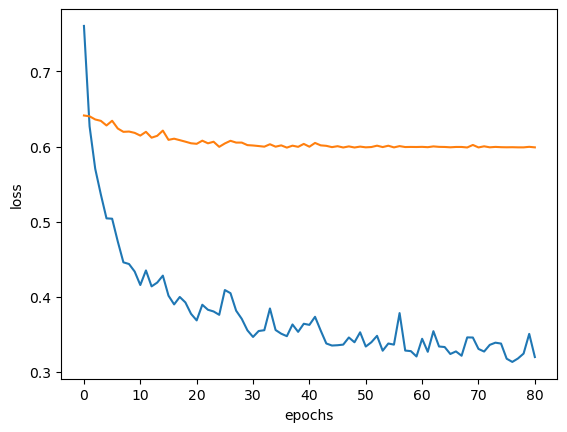

In [13]:
# graph loss for trainging and validation
# train_loss = history.history['loss']
# val_loss   = history.history['val_loss']

#train_acc  = history.history['acc']
#val_acc    = history.history['val_acc']
xc         = range(epochs + 1)

#print(dir(history))
#print(history.history.keys())   #  dict_keys(['loss', 'binary_accuracy', 'mean_squared_error', 'auc', 'val_loss', 'val_binary_accuracy', 'val_mean_squared_error', 'val_auc'])
#print(train_loss)
#print(history.epoch)  # [0]
# print(xc)  #  range(0, 80)  type range

plt.figure()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.show()

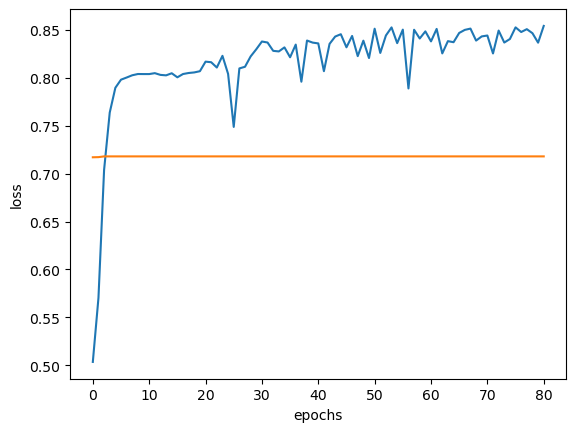

In [14]:
plt.figure()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.show()

### Try Loading final keras file as model

In [15]:
# final_seg_res50_v2.keras
import keras
#classification = keras.saving.load_model("vgg19_final.keras")
seg_model = keras.saving.load_model("final_seg_res50.keras")

### Testing

In [19]:
from glob import glob

test_img_paths = 'test_seg/ISIC2018_Task1-2_Test_Input/*.jpg'
test_gt_paths = 'test_seg_gt/ISIC2018_Task1_Test_GroundTruth/*.png'

test_images = glob(test_img_paths)
test_gts = glob(test_gt_paths)

print(len(test_images))  # 1000
print(len(test_gts))    # 1000

test_images_df = pd.DataFrame(test_images)
test_images_df.columns = ["image_path"]

test_images_df["test_image_id"] = test_images_df["image_path"].apply(lambda x: os.path.basename(x).replace(".jpg", ""))

test_gt_df = pd.DataFrame(test_gts)
test_gt_df.columns = ["gt_path"]

test_gt_df["test_gt_id"] = test_gt_df["gt_path"].apply(lambda x : os.path.basename(x).replace("_segmentation.png", ""))

# print(test_images_df.sample(5))
# print(test_gt_df.sample(5))

test_images_df["gt_path"] = test_images_df["test_image_id"].apply(lambda x : test_gt_df[test_gt_df["test_gt_id"] == x]["gt_path"].to_list()[0] )

test_images_df.sample(5)

1000
1000


,image_path,test_image_id,gt_path
289,test_seg/ISIC2018_Task1-2_Test_Input/ISIC_0036...,ISIC_0036302,test_seg_gt/ISIC2018_Task1_Test_GroundTruth/IS...
506,test_seg/ISIC2018_Task1-2_Test_Input/ISIC_0036...,ISIC_0036153,test_seg_gt/ISIC2018_Task1_Test_GroundTruth/IS...
320,test_seg/ISIC2018_Task1-2_Test_Input/ISIC_0023...,ISIC_0023696,test_seg_gt/ISIC2018_Task1_Test_GroundTruth/IS...
884,test_seg/ISIC2018_Task1-2_Test_Input/ISIC_0016...,ISIC_0016197,test_seg_gt/ISIC2018_Task1_Test_GroundTruth/IS...
282,test_seg/ISIC2018_Task1-2_Test_Input/ISIC_0018...,ISIC_0018377,test_seg_gt/ISIC2018_Task1_Test_GroundTruth/IS...


In [8]:
import tensorflow.keras.backend as K
import tensorflow as tf

def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection / union


def dice_score(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score




# Dice loss according dice coefficient
def dice_loss(y_true, y_pred):
    loss = 1 - dice_score(y_true, y_pred)
    return loss


# Jacard loss
def jaccard_loss(output, target, axis=(0, 1, 2), smooth=1e-5):
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    jaccard = 1 - (inse + smooth) / (l + r - inse + smooth)
    jaccard = tf.reduce_mean(jaccard)
    return jaccard


# Tversky index
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + 1) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + 1)


# Focal loss according to tversky index
def focal_tversky_loss(y_true, y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)


def get_loss(loss_name, logger=None):
    if loss_name == 'dice_loss':
        loss = dice_loss
    elif loss_name == 'jaccard_loss':
        loss = jaccard_loss
    elif loss_name == 'focal_tversky_loss':
        loss = focal_tversky_loss
    else:
        print(f"loss_name: {loss_name} is not supported!")
    print(f"loss: {loss_name} is successfully created!")
    #else:
        #value_error_log(logger, f"loss_name: {loss_name} is not supported!")
    #log_print(logger, f"loss: {loss_name} is successfully created!")
    return loss

img_size = 256

In [9]:
# Load UNET res50  model  TEST

unet_model = keras.saving.load_model("saved_models/ISIC_2016/unet_res50/usual_4/exp_1/model", custom_objects={'dice_score': dice_score,
                                                                                                              'iou': iou,
                                                                                                              'dice_loss': dice_loss,
                                                                                                              'jaccard_loss':jaccard_loss,
                                                                                                              'tversky':tversky,
                                                                                                              'focal_tversky_loss': focal_tversky_loss,
                                                                                                              'get_loss': get_loss})
# Complete metadata: {'class_name': 'MeanMetricWrapper', 'name': 'dice_score', 'dtype': 'float32', 'config': {'name': 'dice_score', 'dtype': 'float32'}, 'shared_object_id': 494}

img_0.shape = (2000, 3008, 3)
img.shape = (256, 256, 3)
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 20ms/step
<class 'numpy.ndarray'>
y_pred.shape = (1, 256, 256, 1)
len(y_pred) = 1
y_pred.shape = (256, 256, 1)
len(y_pred) = 256
img_mask.shape = (256, 256)


(-0.5, 255.5, 255.5, -0.5)

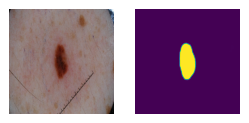

In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import shutil
from PIL import Image
import cv2
from keras.preprocessing import image

test_folder = "test_seg/ISIC2018_Task1-2_Test_Input/"
#test_file = "ISIC_0012169.jpg"
test_file = "ISIC_0012302.jpg"

fig1 = plt.figure(figsize=(5, 5), dpi=92)   # 1080p 24" monitor
graph_rows = 1
graph_columns = 3

the_img = image.load_img(os.path.join(test_folder, test_file), target_size=(img_size, img_size))
fig1.add_subplot(graph_rows, graph_columns, 1)
plt.imshow(the_img)
plt.axis('off')

img_0 = cv2.imread(os.path.join(test_folder, test_file))
print(f"img_0.shape = {img_0.shape}")
img = cv2.resize(img_0, (img_size, img_size))
print(f"img.shape = {img.shape}")
img_1 = img[..., ::-1]
print(f"img_1.shape = {img_1.shape}")
img_1 = img_1 / 255
img_1 = img_1.reshape((1,img_size,img_size,3))

# img_1 = np.array(the_img)
# print(f"img_1.shape = {img_1.shape}")
# img_1 = img_1//(img_size-1)
# img_1 = img_1.reshape((1,img_size,img_size,3))

channel = 0
y_pred = unet_model.predict(img_1) #[..., channel]
#print(y_pred)
print(type(y_pred))
print(f"y_pred.shape = {y_pred.shape}")
print(f"len(y_pred) = {len(y_pred)}")
#y_pred = y_pred[..., 0]
y_pred = y_pred[0, ...]
print(f"y_pred.shape = {y_pred.shape}")
print(f"len(y_pred) = {len(y_pred)}")

img_mask = np.squeeze(y_pred)
print(f"img_mask.shape = {img_mask.shape}")



fig1.add_subplot(graph_rows, graph_columns, 2)
plt.imshow(img_mask)
plt.axis('off')



img_size = 256
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 19ms/step
x.shape = (256, 256, 1)
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 19ms/step
x.shape = (256, 256, 1)
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 19ms/step
x.shape = (256, 256, 1)
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 20ms/step
x.shape = (256, 256, 1)
img_1.shape = (256, 256, 3)
1/1 [==============================] - 0s 19ms/step
x.shape = (256, 256, 1)


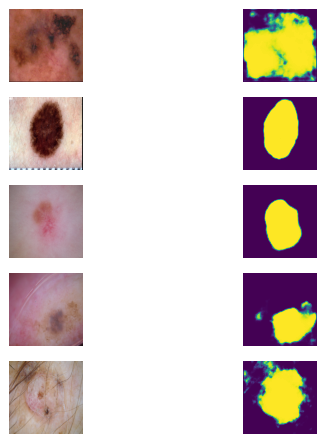

In [59]:
import cv2
from keras.preprocessing import image
from PIL import Image
import numpy as np

print(f"img_size = {img_size}")

fig = plt.figure(figsize=(6, 6), dpi=92)   # 1080p 24" monitor
graph_rows = 5
graph_columns = 2

selected_df = test_images_df.sample(5)

g_idx = 1
for idx, a_row in selected_df.iterrows():
    imgPath = a_row['image_path']
    the_img = image.load_img(imgPath, target_size=(img_size, img_size))

    fig.add_subplot(graph_rows, graph_columns, g_idx)
    plt.imshow(the_img)
    plt.axis('off')

    img_1 = np.array(the_img)
    print(f"img_1.shape = {img_1.shape}")
    img_1 = img_1/255
    img_1 = img_1.reshape((1,256,256,3))
    #result = seg_model.predict(img_1)
    result = unet_model.predict(img_1)
    x = result[0,:, :, :]
    fig.add_subplot(graph_rows, graph_columns, g_idx + 1)
    plt.imshow(x)
    #plt.imshow(np.squeeze(result))
    plt.axis('off')
    # import matplotlib.image

    # matplotlib.image.imsave(f"your_file_{g_idx}.jpg", x)
    print(f"x.shape = {x.shape}")
    arr = x*255
    #arr = np.ascontiguousarray(arr.transpose(1,2,0))
    im = Image.fromarray(arr, 'RGBA')
    im.save(f"your_file_{g_idx}.png")
    g_idx += 2

